# Important note

**This code only works if you already have `climate_merged.csv` and `climate_with_states.csv` in the same directory with this file already.**

At least on my computer.

Downloading has some issues. Namely
1) I think the website is blocking my IP address or something
2) Jupyter notebook can't handle downloading ~1GB of data. Download this as a python file to fix that.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import time
import gc
import geopy
from geopy.geocoders import Nominatim
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Part 1: Downloading the data
# And merging it

# ChatGPT wrote this function
def read_csv_from_web(url):
    # Step 1: Fetch the webpage content
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        csv_data = response.text

        # Step 2: Parse the CSV data
        # Use StringIO to read the CSV from the string
        csv_file = StringIO(csv_data)
        df = pd.read_csv(csv_file)

        # Display the DataFrame
        return df
    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
        
# And this one
def get_csv_links(url):
    """Fetch all CSV links from the given webpage."""
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    csv_links = []
    for link in soup.find_all('a', href=True):
        if link['href'].endswith('.csv'):
            csv_links.append(link['href'])
    
    # Convert relative URLs to absolute URLs if necessary
    base_url = url.rsplit('/', 1)[0]  # Get the base URL
    csv_links = [link if link.startswith('http') else f"{base_url}/{link}" for link in csv_links]
    
    print(csv_links)
    return csv_links

# I wrote this one though (I think)
def get_ith_dataframe(url, i):
    links = get_csv_links(url)
    df = pd.read_csv(links[i])
    return df

def download_all_data():
    if os.path.isfile("climate_merged.csv"):
        return
    
    LANDING_PAGE_URL = "https://www.ncei.noaa.gov/data/normals-hourly/1991-2020/access/"
    LINKS = get_csv_links(LANDING_PAGE_URL)
    NUM_LINKS = 467
    assert len(LINKS) == NUM_LINKS
    
    dataframes = []
    for i, url in enumerate(LINKS):
        df = pd.read_csv(url)
        # df.to_csv(f"{i}.csv", index=False)
        dataframes.append(df)
        del df
        gc.collect()
        print(f"downloaded dataset # {i}")
        
    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.to_csv("climate_merged.csv", index = False)
    
download_all_data()

In [3]:
# Now we map geographic locations to states
def add_states():
    if os.path.isfile("climate_with_states.csv"):
        return
    
    merged_df = pd.read_csv("climate_merged.csv")
    # Remove columns we don't need
    merged_df = merged_df[["LATITUDE", "LONGITUDE"]]
    # Remove duplicates. This will make processing way faster
    merged_df = merged_df.drop_duplicates()
    
    geolocator = Nominatim(user_agent="geoapiExercises")
    def get_state(latitude, longitude):
        coords = str(latitude) + "," + str(longitude)
        location = geolocator.reverse(coords)
        address = location.raw['address']
        state = address.get('state', '')
        return state
        # print(location)
        
    original_df = pd.read_csv("climate_merged.csv")
    states_list = []
    for i in range(original_df.shape[0]):
        location = original_df.LATITUDE[i], original_df.LONGITUDE[i]
        states_list.append(states_dict[location])

    original_df["STATE"] = states_list
    
    original_df.to_csv("climate_with_states.csv", index = False)

add_states()

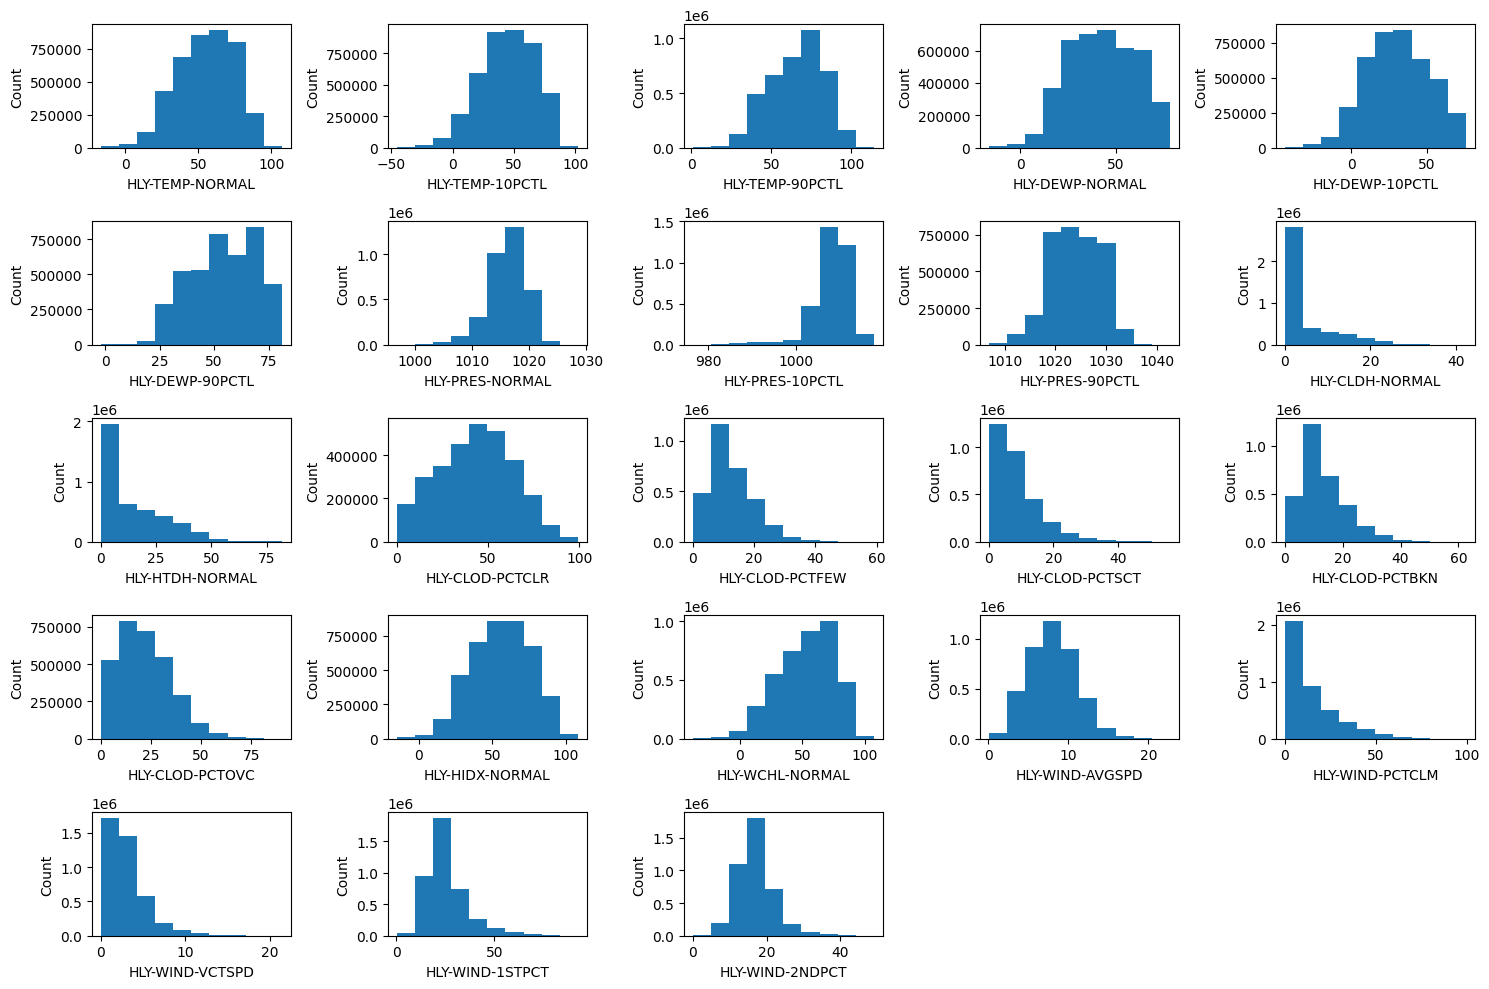

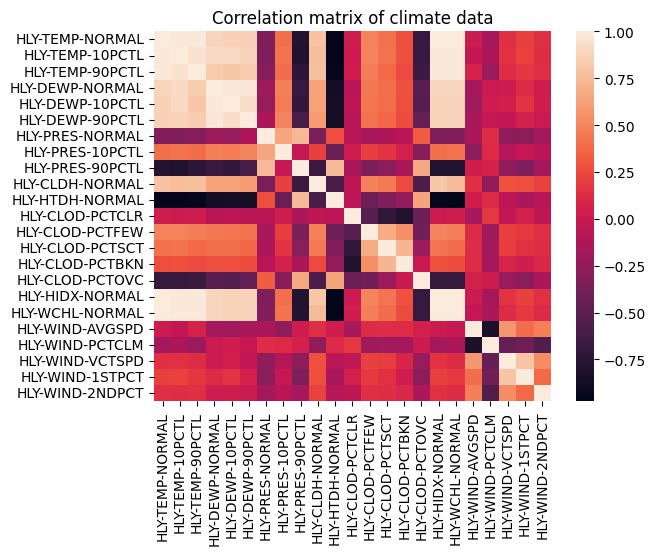

In [5]:
# EDA

def eda():
    # Part 1: Histograms
    merged_df = pd.read_csv("climate_merged.csv")
    MEAS_COLUMNS = ['HLY-TEMP-NORMAL', 'HLY-TEMP-10PCTL', 'HLY-TEMP-90PCTL', 'HLY-DEWP-NORMAL', 'HLY-DEWP-10PCTL', 'HLY-DEWP-90PCTL', 'HLY-PRES-NORMAL', 'HLY-PRES-10PCTL', 'HLY-PRES-90PCTL', 'HLY-CLDH-NORMAL', 'HLY-HTDH-NORMAL', 'HLY-CLOD-PCTCLR', 'HLY-CLOD-PCTFEW', 'HLY-CLOD-PCTSCT', 'HLY-CLOD-PCTBKN', 'HLY-CLOD-PCTOVC', 'HLY-HIDX-NORMAL', 'HLY-WCHL-NORMAL', 'HLY-WIND-AVGSPD', 'HLY-WIND-PCTCLM', 'HLY-WIND-VCTDIR', 'HLY-WIND-VCTSPD', 'HLY-WIND-1STDIR', 'HLY-WIND-1STPCT', 'HLY-WIND-2NDDIR', 'HLY-WIND-2NDPCT']
    QUANT_MEAS = ['HLY-TEMP-NORMAL', 'HLY-TEMP-10PCTL', 'HLY-TEMP-90PCTL', 'HLY-DEWP-NORMAL', 'HLY-DEWP-10PCTL', 'HLY-DEWP-90PCTL', 'HLY-PRES-NORMAL', 'HLY-PRES-10PCTL', 'HLY-PRES-90PCTL', 'HLY-CLDH-NORMAL', 'HLY-HTDH-NORMAL', 'HLY-CLOD-PCTCLR', 'HLY-CLOD-PCTFEW', 'HLY-CLOD-PCTSCT', 'HLY-CLOD-PCTBKN', 'HLY-CLOD-PCTOVC', 'HLY-HIDX-NORMAL', 'HLY-WCHL-NORMAL', 'HLY-WIND-AVGSPD', 'HLY-WIND-PCTCLM', 'HLY-WIND-VCTSPD', 'HLY-WIND-1STPCT', 'HLY-WIND-2NDPCT']
    
    def make_histogram(colname):
        measurements = merged_df[colname][merged_df["years_" + colname] != 0]
        plt.hist(measurements)
        plt.xlabel(colname)
        plt.ylabel("Count")
    
    plt.figure(figsize = (15,10))
    for i, colname in enumerate(QUANT_MEAS):
        plt.subplot(5, 5, i + 1)
        plt.tight_layout()
        make_histogram(colname)
        
    plt.show()
    
    # Part 2: correlation matrix
    quant_df = merged_df[QUANT_MEAS]
    quant_df = quant_df.replace(-9999, np.nan)
    corr_matrix = quant_df.corr()
    sns.heatmap(corr_matrix)
    plt.title("Correlation matrix of climate data")
    plt.show()
    
eda()

In [10]:
# Aggregating climate data by state

def aggregate_climate_data_by_state():
    states_df = pd.read_csv("climate_with_states.csv")
    US_STATES = ['Montana',
       'Colorado', 'California', 'Nevada', 'Arizona', 'West Virginia',
       'Tennessee', 'North Carolina', 'Georgia', 'Kentucky', 'Alabama',
       'Florida', 'South Carolina', 'Illinois', 'Texas', 'Kansas',
       'Arkansas', 'Louisiana', 'Mississippi', 'Missouri', 'Oklahoma',
       'New York', 'Pennsylvania', 'New Hampshire', 'Ohio', 'Virginia',
       'Maryland', 'Delaware', 'New Jersey', 'Maine', 'Massachusetts',
       'Connecticut', 'Vermont', 'Rhode Island', 'Michigan', 'Indiana',
       'Wisconsin', 'Minnesota', 'North Dakota', 'South Dakota', 'Iowa',
       'Nebraska', 'Hawaii', 'New Mexico', 'Wyoming', 'Utah', 'Idaho',
       'Washington', 'Oregon', 'Alaska']
    
    
    QUANT_MEAS = ['HLY-TEMP-NORMAL', 'HLY-TEMP-10PCTL', 'HLY-TEMP-90PCTL', 'HLY-DEWP-NORMAL', 'HLY-DEWP-10PCTL', 'HLY-DEWP-90PCTL', 'HLY-PRES-NORMAL', 'HLY-PRES-10PCTL', 'HLY-PRES-90PCTL', 'HLY-CLDH-NORMAL', 'HLY-HTDH-NORMAL', 'HLY-CLOD-PCTCLR', 'HLY-CLOD-PCTFEW', 'HLY-CLOD-PCTSCT', 'HLY-CLOD-PCTBKN', 'HLY-CLOD-PCTOVC', 'HLY-HIDX-NORMAL', 'HLY-WCHL-NORMAL', 'HLY-WIND-AVGSPD', 'HLY-WIND-PCTCLM', 'HLY-WIND-VCTSPD', 'HLY-WIND-1STPCT', 'HLY-WIND-2NDPCT']
    # We might want to remove columns with pressure from our dataset because they have a lot of missing values
    drop_pressure = False
    if drop_pressure:
        for colname in 'HLY-PRES-NORMAL', 'HLY-PRES-10PCTL', 'HLY-PRES-90PCTL':
            QUANT_MEAS.remove(colname)
    
    
    states_df = states_df[states_df.STATE.isin(US_STATES)]
    # Filter out only the columns we need
    states_df = states_df[[col for col in states_df.columns if not ("years_" in col or "flag_" in col)]]
    # Turn -9999 to missing
    states_df = states_df.replace(-9999, np.nan)
    
    missing_proportions = states_df.groupby(["STATE","month"])[QUANT_MEAS].apply(lambda x: x.isna().mean())
    states_df_grouped = states_df.groupby(["STATE","month"])[QUANT_MEAS].apply(lambda x: x.mean())
    
    MISSING_THRESHOLD = 1 
    # If more than MISSING_THRESHOLD of the observations for one variable for one state for one month are missing, that datapoint is missing
    
    nan_mask = missing_proportions[missing_proportions <= MISSING_THRESHOLD] * 0
    # This is a wacky way to get a dataframe where every statistic is NaN iff more than 50% of the values are missing for that month
    
    assert np.all((nan_mask.isnull() == (missing_proportions > MISSING_THRESHOLD)).all())

    states_df_grouped = states_df_grouped + nan_mask
    
    states_df_grouped.to_csv("climate_by_state_more_vars.csv")
    
aggregate_climate_data_by_state()

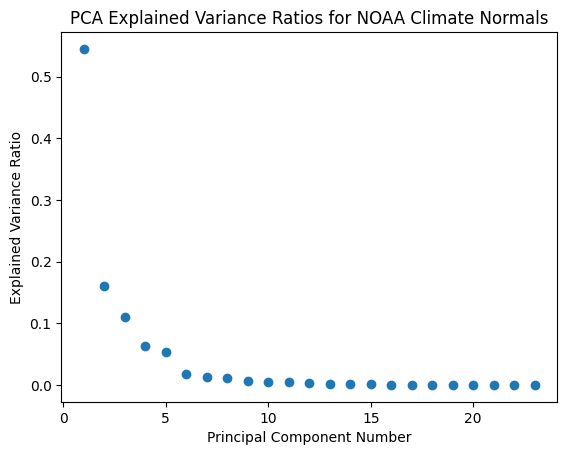

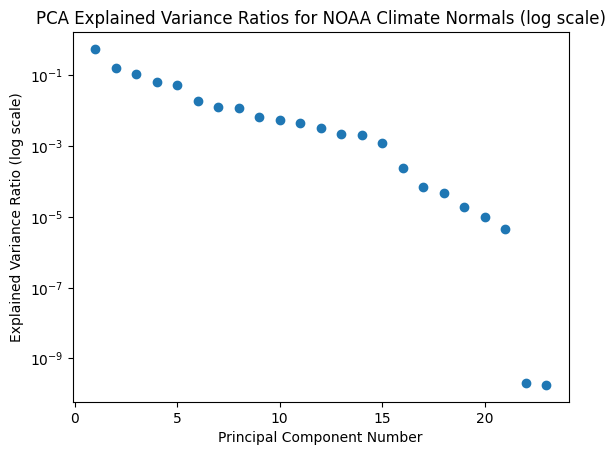

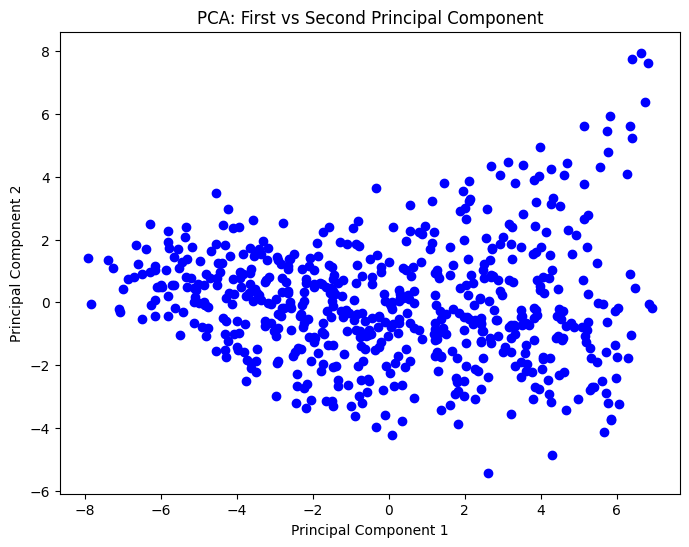

In [19]:
def pca():
    # Step 1: Do the PCA
    df = pd.read_csv("climate_by_state_more_vars.csv", index_col = ('STATE', 'month'))
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_data = scaler.transform(df)
    pca = PCA()
    pca.fit(scaled_data)

    x_pca = pca.transform(scaled_data)
    pca_df = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(x_pca.shape[1])])

    # Step 2: Save it to a file
    
    df_with_pc = df.reset_index()
    for column in pca_df:
        df_with_pc[column] = pca_df[column]
    df_with_pc.to_csv("climate_principal_components.csv", index = False)

    # Step 3: Graph explained variance ratio
    plt.scatter(range(1,df.shape[1] + 1), pca.explained_variance_ratio_)
    plt.xlabel("Principal Component Number")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Explained Variance Ratios for NOAA Climate Normals")
    plt.show()

    plt.scatter(range(1,df.shape[1] + 1), pca.explained_variance_ratio_)
    plt.xlabel("Principal Component Number")
    plt.ylabel("Explained Variance Ratio (log scale)")
    plt.yscale("log")
    plt.title("PCA Explained Variance Ratios for NOAA Climate Normals (log scale)")
    plt.show()

    # Step 4: Graph the first 2 principal components
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First vs Second Principal Component')
    plt.show()

    # Sources:
    # https://datascienceplus.com/principal-component-analysis-pca-with-python/
    # ChatGPT
    
pca()